In [1]:
import json
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# 1. Summarise Benchmarks

In [2]:
def summarise_benchmark(path):
    tasks = json.load(open(path))
    meta = [t["metadata"] for t in tasks]
    counts = {
        k: Counter(m[k] for m in meta)
        for k in ["num_rules","num_base_facts","proof_depth","allow_recursion","reasoning_type"]
    }
    counts["label"] = Counter(t["t"] for t in tasks)
    return len(tasks), counts

In [3]:
# Propositional
n_prop, counts_prop = summarise_benchmark("propositional_benchmark.json")
print(f"Propositional tasks: {n_prop}")
print(counts_prop)

# First-Order
n_fol, counts_fol = summarise_benchmark("real_final_first_order_benchmark.json")
print(f"\nFirst-order tasks: {n_fol}")
print(counts_fol)

Propositional tasks: 1197
{'num_rules': Counter({35: 390, 25: 360, 15: 271, 5: 176}), 'num_base_facts': Counter({3: 256, 6: 242, 9: 238, 15: 235, 12: 226}), 'proof_depth': Counter({'not applicable': 392, 1: 267, 5: 212, 10: 156, 20: 100, 3: 22, 2: 15, 4: 14, 6: 5, 8: 4, 7: 3, 16: 2, 15: 1, 11: 1, 13: 1, 18: 1, 14: 1}), 'allow_recursion': Counter({True: 600, False: 597}), 'reasoning_type': Counter({'deduction': 650, 'abduction': 547}), 'label': Counter({'false': 782, 'true': 415})}

First-order tasks: 1280
{'num_rules': Counter({20: 320, 25: 320, 10: 240, 15: 240, 5: 160}), 'num_base_facts': Counter({4: 256, 8: 256, 12: 256, 16: 256, 20: 256}), 'proof_depth': Counter({1: 400, 5: 400, 10: 320, 20: 160}), 'allow_recursion': Counter({True: 640, False: 640}), 'reasoning_type': Counter({'deduction': 640, 'abduction': 640}), 'label': Counter({'true': 640, 'false': 640})}


# 2. Load Model Results

In [4]:
FILES = {
    "llama2": [
        ("prop",  "shuffled", "results/llama2/llama2_prop_shuffled.json"),
        ("fol",   "shuffled", "results/llama2/llama2_fol_shuffled.json"),
    ],
    "flan_t5": [
        ("prop",  "shuffled", "results/flan/flan_t5_prop_shuffled.json"),
        ("fol",   "shuffled", "results/flan/flan_t5_fol_shuffled.json"),
    ],
    "gemma2": [
        ("prop",  "shuffled", "results/gemma2/gemma2_prop_shuffled.json"),
        ("fol",   "shuffled", "results/gemma2/gemma2_fol_shuffled.json"),
    ],
}

In [5]:
records = []
for model, runs in FILES.items():
    for bench, order, fn in runs:
        data = json.load(open(fn))
        for rec in data:
            records.append({
                "model": model,
                "benchmark": bench,
                "order": order,
                "t": rec["t"].lower(),
                "pred": rec.get("pred","").lower(),
                **rec["metadata"]
            })

df = pd.DataFrame(records)
df["correct"] = (df["t"] == df["pred"])
print(f"\nLoaded {len(df)} predictions across {df['model'].nunique()} models and {df['benchmark'].nunique()} benchmarks.\n")
display(df.head())



Loaded 6261 predictions across 3 models and 2 benchmarks.



,model,benchmark,order,t,pred,num_rules,max_body_length,allow_recursion,branching_factor,proof_depth,num_base_facts,depth,reasoning_type,conclusion,explanation,non_explanation,correct
0,llama2,prop,shuffled,true,false,5,3,True,2,1,3,1,deduction,NaN,NaN,NaN,False
1,llama2,prop,shuffled,true,false,5,3,True,2,1,3,1,deduction,NaN,NaN,NaN,False
2,llama2,prop,shuffled,false,false,5,3,True,2,1,3,not applicable,deduction,NaN,NaN,NaN,True
3,llama2,prop,shuffled,false,true,5,3,True,2,1,3,not applicable,deduction,NaN,NaN,NaN,False
4,llama2,prop,shuffled,false,false,5,3,True,2,1,3,not applicable,deduction,NaN,NaN,NaN,True


# 3. Overall Accuracy Table (all benchmarks)

In [6]:
# 3. Overall Accuracy Table (shuffled only)
df_shuf = df[df["order"] == "shuffled"]

overall_shuf = (
    df_shuf
    .groupby(["model", "benchmark"])["correct"]
    .mean()
    .mul(100)
    .round(1)
    .unstack("benchmark")
)

print("Overall accuracy (%) by model and benchmark (shuffled only):")
display(overall_shuf)

Overall accuracy (%) by model and benchmark (shuffled only):


benchmark,fol,prop
model,,
flan_t5,70.9,79.6
gemma2,61.1,89.3
llama2,45.9,64.1


# 4. Filter to FOL + shuffled only

In [7]:
df_fol_shuf = df[(df["benchmark"]=="fol") & (df["order"]=="shuffled")]

# 5. Plotting Functions

In [8]:
plt.rcParams.update({
    "font.size": 14,
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
})

def plot_vs_depth(data, ax):
    grp = (
        data[data["t"]=="true"]
        .groupby(["proof_depth","model"])["correct"]
        .mean().mul(100).reset_index()
    )
    for m, sub in grp.groupby("model"):
        ax.plot(sub["proof_depth"], sub["correct"], marker="o", label=m)
    ax.set(
        xlabel="Proof Depth",
        ylabel="Accuracy (%)",
        title="Accuracy vs Proof Depth (only includes true tasks)",
        ylim=(0,100)
    )
    ax.legend(); ax.grid(alpha=0.3)

def plot_vs_rules(data, ax):
    grp = (
        data.groupby(["num_rules","model"])["correct"]
        .mean().mul(100).reset_index()
    )
    for m, sub in grp.groupby("model"):
        ax.plot(sub["num_rules"], sub["correct"], marker="o", label=m)
    ax.set(
        xlabel="Number of Rules",
        ylabel="Accuracy (%)",
        title="Accuracy vs Number of Rules",
        xticks=sorted(data["num_rules"].unique()),
        ylim=(0,100)
    )
    ax.legend(); ax.grid(alpha=0.3)

def plot_vs_facts(data, ax):
    grp = (
        data.groupby(["num_base_facts","model"])["correct"]
        .mean().mul(100).reset_index()
    )
    for m, sub in grp.groupby("model"):
        ax.plot(sub["num_base_facts"], sub["correct"], marker="o", label=m)
    ax.set(
        xlabel="Number of Facts",
        ylabel="Accuracy (%)",
        title="Accuracy vs Number of Facts",
        xticks=sorted(data["num_base_facts"].unique()),
        ylim=(0,100)
    )
    ax.legend(); ax.grid(alpha=0.3)


def plot_deduction_vs_abduction(data, ax):
    MODEL_COLORS = {"flan_t5":"C0","gemma2":"C1","llama2":"C2"}
    x = [0,1]  # 0=abduction,1=deduction
    width = 0.2
    for i, model in enumerate(data["model"].unique()):
        sub = data[data["model"]==model]
        accs = sub.groupby("reasoning_type")["correct"]\
                  .mean().mul(100)\
                  .reindex(["abduction","deduction"])
        ax.bar(
            [xi + width*i for xi in x],
            accs,
            width=width,
            color=MODEL_COLORS[model],
            label=model
        )
    ax.set(
        xlabel="Reasoning Type",
        ylabel="Accuracy (%)",
        title="Accuracy vs Reasoning Type",
        xticks=x,
        xticklabels=["Abduction","Deduction"],
        ylim=(0,100)
    )
    ax.legend(); ax.grid(alpha=0.3)


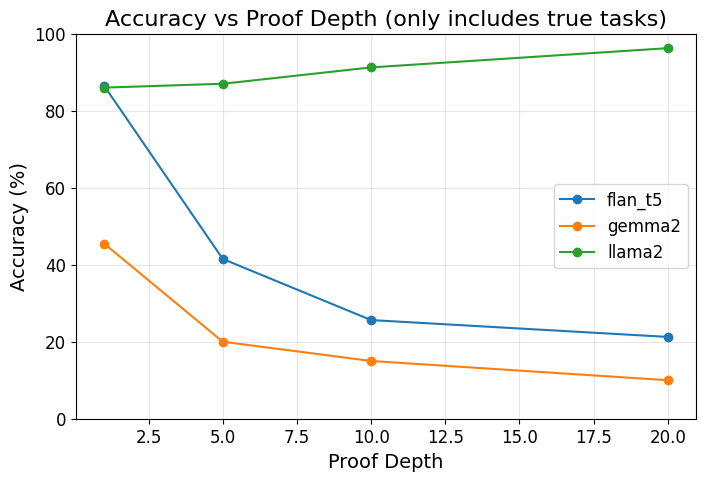

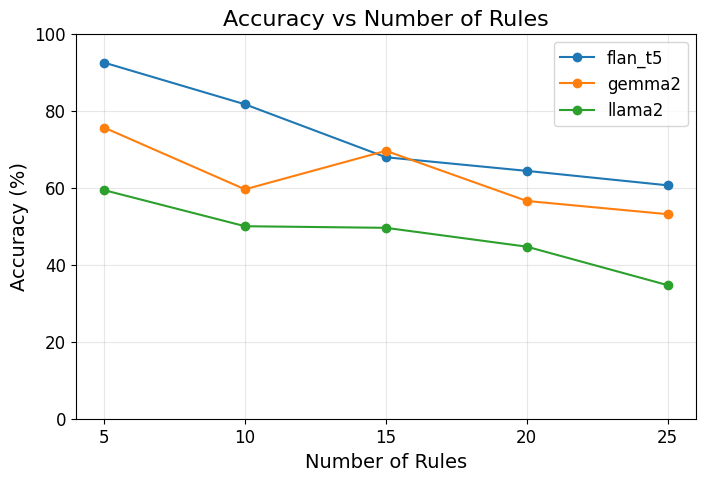

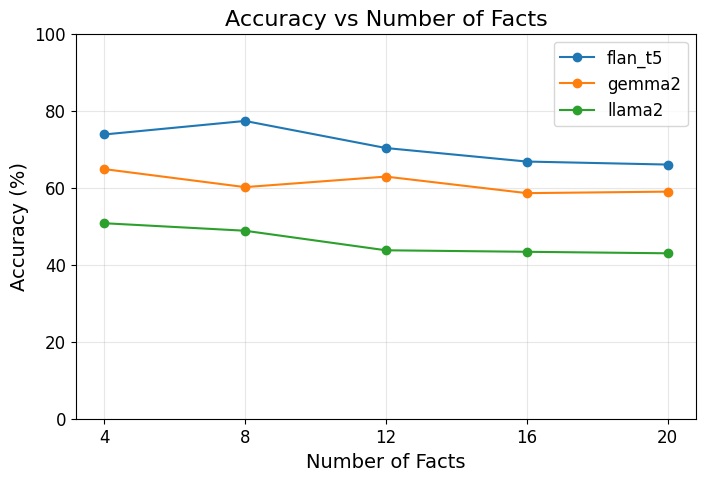

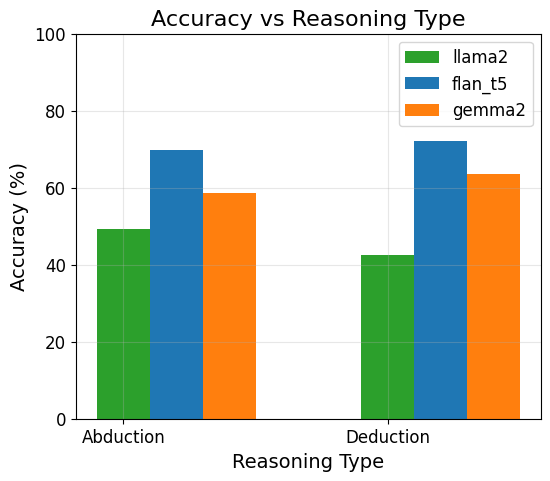

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
plot_vs_depth(df_fol_shuf, ax)
plt.show()

fig, ax = plt.subplots(1,1,figsize=(8,5))
plot_vs_rules(df_fol_shuf, ax)
plt.show()

fig, ax = plt.subplots(1,1,figsize=(8,5))
plot_vs_facts(df_fol_shuf, ax)
plt.show()

fig, ax = plt.subplots(1,1,figsize=(6,5))
plot_deduction_vs_abduction(df_fol_shuf, ax)
plt.show()


In [ ]:
# summary tables for FOL+shuffled, but only for true tasks when computing proof_depth
simple_tables = {}

df_true = df_fol_shuf[df_fol_shuf["t"] == "true"]
table_pd = (
    df_true
      .groupby(["proof_depth","model"])["correct"]
      .mean().mul(100).round(1)
      .unstack("model")
      .reset_index()
)
print("=== Accuracy by proof_depth (FOL, shuffled, TRUE only) ===")
display(table_pd)
simple_tables["proof_depth"] = table_pd

for col in ["num_rules", "num_base_facts", "allow_recursion", "reasoning_type"]:
    table = (
        df_fol_shuf
          .groupby([col, "model"])["correct"]
          .mean().mul(100).round(1)
          .unstack("model")
          .reset_index()
    )
    print(f"\n=== Accuracy by {col} (FOL, shuffled) ===")
    display(table)
    simple_tables[col] = table


=== Accuracy by proof_depth (FOL, shuffled, TRUE only) ===


model,proof_depth,flan_t5,gemma2,llama2
0,1,86.5,45.5,86.0
1,5,41.5,20.0,87.0
2,10,25.6,15.0,91.2
3,20,21.2,10.0,96.2



=== Accuracy by num_rules (FOL, shuffled) ===


model,num_rules,flan_t5,gemma2,llama2
0,5,92.5,75.6,59.4
1,10,81.7,59.6,50.0
2,15,67.9,69.6,49.6
3,20,64.4,56.6,44.7
4,25,60.6,53.1,34.7



=== Accuracy by num_base_facts (FOL, shuffled) ===


model,num_base_facts,flan_t5,gemma2,llama2
0,4,73.8,64.8,50.8
1,8,77.3,60.2,48.8
2,12,70.3,62.9,43.8
3,16,66.8,58.6,43.4
4,20,66.0,59.0,43.0



=== Accuracy by allow_recursion (FOL, shuffled) ===


model,allow_recursion,flan_t5,gemma2,llama2
0,False,69.2,58.8,47.3
1,True,72.5,63.4,44.5



=== Accuracy by reasoning_type (FOL, shuffled) ===


model,reasoning_type,flan_t5,gemma2,llama2
0,abduction,69.7,58.6,49.4
1,deduction,72.0,63.6,42.5


# Precision and Recall

In [ ]:
import pandas as pd

df_shuf = df[df["order"]=="shuffled"]

def compute_confusion_and_pr(df_subset):
    # we treat "true" as the positive class
    y_true = (df_subset["t"] == "true")
    y_pred = (df_subset["pred"] == "true")
    TP = int(((y_true) & (y_pred)).sum())
    TN = int(((~y_true) & (~y_pred)).sum())
    FP = int(((~y_true) & (y_pred)).sum())
    FN = int(((y_true) & (~y_pred)).sum())
    precision = TP / (TP + FP) if (TP + FP) > 0 else float("nan")
    recall    = TP / (TP + FN) if (TP + FN) > 0 else float("nan")
    return {"TP":TP, "FP":FP, "FN":FN, "TN":TN,
            "Precision": precision*100, "Recall": recall*100}

results = []
for model in df_shuf["model"].unique():
    for bench in ["fol","prop"]:
        sub = df_shuf[(df_shuf["model"]==model) & (df_shuf["benchmark"]==bench)]
        if len(sub)==0: 
            continue
        m = compute_confusion_and_pr(sub)
        m.update({"model":model, "benchmark":bench, "n": len(sub)})
        results.append(m)

conf_df = pd.DataFrame(results)[
    ["model","benchmark","n","TP","FP","FN","TN","Precision","Recall"]
]

print("=== Confusion matrices, precision & recall (shuffled only) ===")
display(conf_df)


=== Confusion matrices, precision & recall (shuffled only) ===


,model,benchmark,n,TP,FP,FN,TN,Precision,Recall
0,llama2,fol,1280,569,525,71,115,52.010969,88.906250
1,llama2,prop,807,3,12,278,514,20.000000,1.067616
2,flan_t5,fol,1280,314,47,326,593,86.980609,49.062500
3,flan_t5,prop,807,270,154,11,372,63.679245,96.085409
4,gemma2,fol,1280,163,20,477,620,89.071038,25.468750
5,gemma2,prop,807,260,65,21,461,80.000000,92.526690


In [17]:
# ------------------------------------------------------------------------------
# 8.  Identify tasks that EVERY model got wrong (FOL, shuffled)
# ------------------------------------------------------------------------------

# 8.1 – add a task_id to every prediction -------------------------------------
# (we assume the order in each result file == order in the benchmark JSON)
task_map = {
    "fol": json.load(open("real_final_first_order_benchmark.json")),
    "prop": json.load(open("propositional_benchmark.json")),
}

records = []
for model, runs in FILES.items():
    for bench, order, fn in runs:
        data = json.load(open(fn))
        for idx, rec in enumerate(data):
            records.append({
                "task_id"   : idx,            # <-- new
                "model"     : model,
                "benchmark" : bench,
                "order"     : order,
                "t"         : rec["t"].lower(),
                "pred"      : rec.get("pred","").lower(),
                **rec["metadata"]
            })

df = pd.DataFrame(records)
df["correct"] = (df["t"] == df["pred"])

# 8.2 – restrict to FOL + shuffled --------------------------------------------
df_fol_shuf = df[(df["benchmark"]=="fol") & (df["order"]=="shuffled")]

# 8.3 – find task_ids that all three models missed ----------------------------
wrong_counts = (
    df_fol_shuf.groupby("task_id")["correct"]
               .sum()            # 0 = all wrong, 1/2/3 = at least one correct
)

task_ids_all_wrong = wrong_counts[wrong_counts == 0].index.tolist()
print(f"{len(task_ids_all_wrong)} tasks were missed by ALL models.")

# 8.4 – collect those tasks with meta-info ------------------------------------
wrong_tasks = []
for tid in task_ids_all_wrong:
    task_dict = task_map["fol"][tid]
    wrong_tasks.append({
        "task_id"   : tid,
        "natural language"   : task_dict["natural language"],
        "q"     : task_dict["q"],
        "t"     : task_dict["t"],
        "depth"     : task_dict["metadata"]["proof_depth"],
        "num_rules" : task_dict["metadata"]["num_rules"],
        "num_facts" : task_dict["metadata"]["num_base_facts"],
    })

wrong_df = pd.DataFrame(wrong_tasks)
display(wrong_df.head())

# (optional) write to file so you can open it in VSCode or similar
wrong_df.to_json("all_models_failed_tasks.json", orient="records", indent=2)


48 tasks were missed by ALL models.


,task_id,natural language,q,t,depth,num_rules,num_facts
0,303,You are given the following information:\nFor ...,hungry(bob).,false,10,10,12
1,387,You are given the following information:\nFor ...,big(book).,false,10,10,20
2,420,You are given the following information:\nFor ...,smooth(phone).,true,5,15,4
3,704,You are given the following information:\nFor ...,angry(dave).,true,1,20,8
4,772,You are given the following information:\nFor ...,busy(george).,true,1,20,12
